In [1]:
import pandas as pd
import anndata as ad
import screenpro as scp

In [2]:
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib import rcParams, rc_context

In [3]:
from matplotlib import font_manager as fm

from matplotlib import rcParams, rc_context

font_files = fm.findSystemFonts(fontpaths=None, fontext='ttf')

for font_file in font_files:
    fm.fontManager.addfont(font_file)

# {f.name for f in matplotlib.font_manager.fontManager.ttflist}

rcParams['font.family'] = ['Arial']

In [4]:
wd = '/data_gilbert/home/aarab/AML/Decitabine-treatment/DAC'

In [5]:
import pandas as pd
from plotnine import *

In [6]:
def get_replicate_score(screen,x_label, y_label):
    adata_ctrl = screen.adata[:,screen.adata.var.targetType.eq('negCtrl')].copy()

    results = {}
    
    for replicate in screen.adata.obs.replicate.unique():

        res = scp.ps.getPhenotypeScore(
            x = screen.adata[screen.adata.obs.query(f'condition == "{x_label}" & replicate == {replicate}').index].X,
            y = screen.adata[screen.adata.obs.query(f'condition == "{y_label}" & replicate == {replicate}').index].X,

            x_ctrl = adata_ctrl[adata_ctrl.obs.query(f'condition == "{x_label}" & replicate == {replicate}').index].X,
            y_ctrl = adata_ctrl[adata_ctrl.obs.query(f'condition == "{y_label}" & replicate == {replicate}').index].X,

            growth_rate=1,
            math = screen.math,
            ave = 'row'
        )
        
        results.update({f'replicate_{replicate}':res})
    
    
    out = pd.DataFrame(
        results,
        index = screen.adata.var.index
    )
    return out

In [7]:
def plot_scatter_with_annotations(ax, phe, gamma, rho, target_name,exp='',selected_size=30, default_size=3):
    # Scatter plot for targeting data
    targeting_data = phe[phe['targetType'] == 'targeting']
    ax.scatter(targeting_data[gamma], targeting_data[rho],
               s=default_size, linewidth=0.3, edgecolors='black', facecolors='#3182bd', label='Targeting')

    # Scatter plot for non-targeting data
    non_targeting_data = phe[phe['targetType'] == 'negCtrl']
    ax.scatter(non_targeting_data[gamma], non_targeting_data[rho],
               s=default_size, linewidth=0, edgecolors='black', facecolors='gray', label='Non-Targeting')

    # Annotate the specified target name with increased size
    target_row = targeting_data[targeting_data['target'] == target_name]
    ax.scatter(target_row[gamma], target_row[rho],
               s=selected_size, linewidth=0.5, edgecolors='black', facecolors='#d73027', label=target_name)
    # # Annotate the specified target name
    # target_row = targeting_data[targeting_data['target'] == target_name]
    # ax.annotate(target_name, (target_row[gamma].iloc[0], target_row[rho].iloc[0]))

    # Set x-axis and y-axis labels
    ax.set_xlabel(f'{exp} gamma score')
    ax.set_ylabel(f'{exp} rho score')

    # # Add legend
    # ax.legend()

    ax.set_title(target_name)
    
    return ax

In [8]:
def plot_ggplot_pca(adata,fill,shape,legend_position= 'top',figure_size= (4.5, 5)):
    pca = pd.concat([
        pd.DataFrame(
            adata.obsm['X_pca'][:,[0,1]],
            index=adata.obs.index,
            columns=['PC-1','PC-2']
        ),
        adata.obs.drop('replicate',axis=1)
    ],axis=1)
    
    pca_p =  (ggplot(pca) 
     + geom_point(aes(
         x = 'PC-1',
         y = 'PC-2',
         fill=fill, 
         shape = shape
     ), color='black', size = 8)
     + theme_classic()
     + theme(
         panel_grid_major   = element_blank(), 
         panel_grid_minor   = element_blank(), 
         panel_background   = element_blank(), 

         legend_background  = element_blank(), 
         legend_position    = legend_position,
         legend_direction   = 'horizontal', # affected by the ncol=2
         # legend_text_legend = element_text(size=8),

         axis_line          = element_line(size=2),
         axis_text_x        = element_text(size=8),
         axis_text_y        = element_text(size=8),
         axis_title_x       = element_text(weight='bold', size=12),
         axis_title_y       = element_text(weight='bold', size=12),

         text               = element_text(font = 'arial'),

         figure_size        = figure_size
     )
    )

    return pca_p

### 

In [13]:
screens = {}

for exp in ['hl60_exp1','molm13_exp','skm1_exp']:
    name = exp.split('_')[0]
    cnt = pd.read_csv(f'{wd}/CRISPRi-screen/{exp}/mergedcountstable.txt',sep='\t', header=list(range(2)),index_col=list(range(1)))
    meta = cnt.columns.to_frame().reset_index(drop=True)
    samples = [f'{exp}_sample_{i+1}' for i in meta.index.to_list()]
    cnt.columns = samples
    meta.index = samples
    meta.columns = ['condition','replicate']
    meta.replicate = meta.replicate.str[-1].astype(int)
    
    oligo = cnt.index.to_frame()
    oligo.index.name = None
    oligo['target'] = oligo.sgId.str.split('_').str[0]
    del oligo['sgId']
    oligo['targetType'] = oligo.target.apply(lambda x: "negCtrl" if x == "non-targeting" else "targeting")
    oligo = oligo.sort_values('target').sort_values('targetType',ascending=False)
    oligo.targetType = pd.Categorical(oligo.targetType,categories=['targeting','negCtrl'])
    
    adata = ad.AnnData(X=cnt.loc[oligo.index,:].T.astype(float) + 1, var=oligo, obs=meta)
    scp.ps.seqDepthNormalization(adata)

    adata_filt = adata[:,adata.to_df().sum(axis=0).gt(0)].copy()

    screens[name] = scp.ScreenPro(adata_filt)

In [14]:
phe = pd.concat([
    get_replicate_score(screens['hl60'],'untreated', 'treated').add_prefix('hl60_rho_'),
    get_replicate_score(screens['hl60'],'T0', 'untreated').add_prefix('hl60_gamma_'),
    
    get_replicate_score(screens['molm13'],'DMSO', 'DAC').add_prefix('molm13_rho_'),
    get_replicate_score(screens['molm13'],'T0', 'DMSO').add_prefix('molm13_gamma_'),

    get_replicate_score(screens['skm1'],'DMSO', 'DAC').add_prefix('skm1_rho_'),
    get_replicate_score(screens['skm1'],'T0', 'DMSO').add_prefix('skm1_gamma_'),
],axis=1).T

pdata = ad.AnnData(X=phe,var=oligo)

pdata.obs['cell_line'] = pdata.obs.index.str.split('_').str[0]
pdata.obs['score'] = pdata.obs.index.str.split('_').str[1]
pdata.obs['replicate'] = pdata.obs.index.str.split('_').str[-1]

### 

In [15]:
sc.tl.pca(pdata)#, svd_solver='arpack')

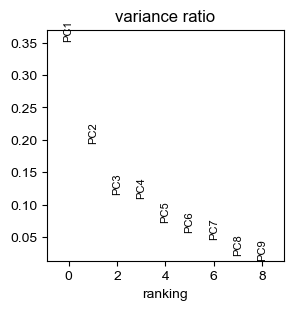

<Figure size 300x300 with 0 Axes>

In [16]:
with rc_context({'figure.figsize': (3, 3)}):
    sc.pl.pca_variance_ratio(pdata, n_pcs=8)
    plt.tight_layout()
    plt.show()

/data_gilbert/home/aarab/anaconda3/envs/mamba/envs/screenpro2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


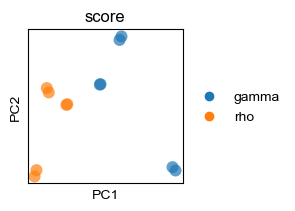

/data_gilbert/home/aarab/anaconda3/envs/mamba/envs/screenpro2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


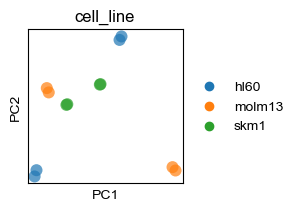

In [17]:
with rc_context({'figure.figsize': (2, 2)}):
    sc.pl.pca_scatter(pdata,color='score',size=300,alpha=0.7)
    sc.pl.pca_scatter(pdata,color='cell_line',size=300,alpha=0.7)

In [18]:
pca = plot_ggplot_pca(pdata,fill = 'cell_line',shape='score',legend_position=None,figure_size= (6, 3.5))

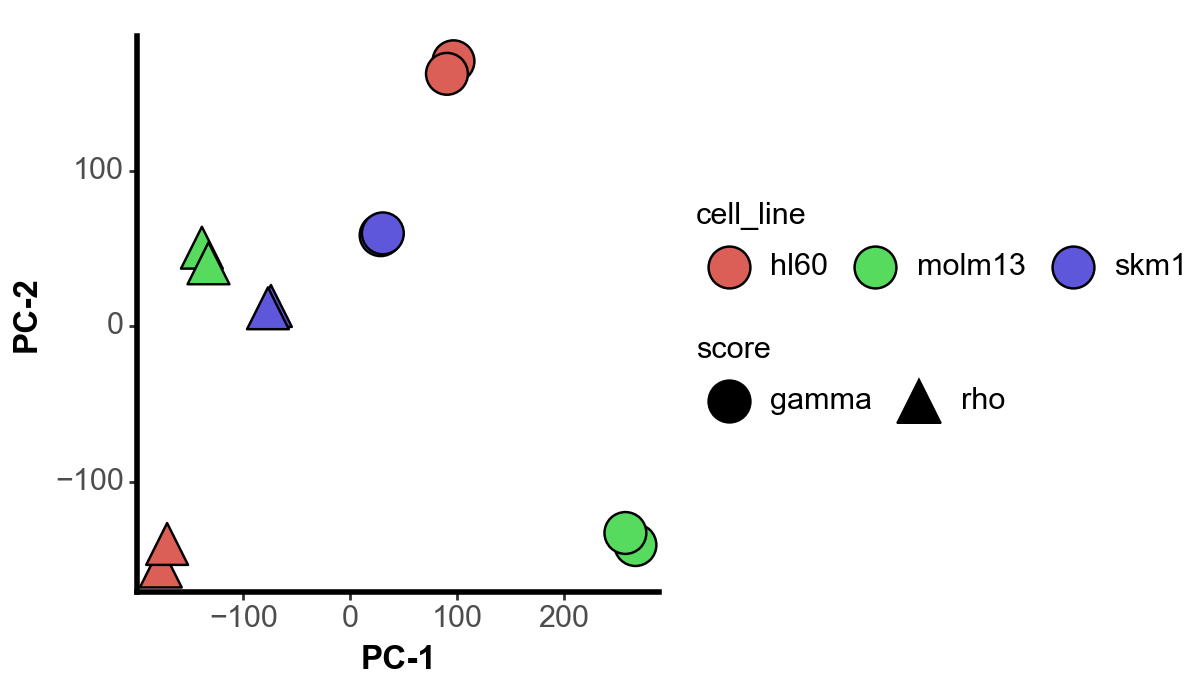

<Figure Size: (600 x 350)>

In [19]:
pca#.save('pca.pdf')

### 

In [20]:
def plot_scatter_for_a_gene_on_three_cell_lines(gene_name):
    # Create subplots and specify the size
    fig, axes = plt.subplots(3, 2, figsize=(6, 9))

    cell_line_names = {
        'hl60':'HL-60',
        'molm13':'MOLM13',
        'skm1':'SKM1',
    }

    for i,rep_num in enumerate([1,2]):
        for j,cell_line in enumerate(['hl60','molm13','skm1']):
            plot_scatter_with_annotations(
                axes[j,i],
                pd.concat([pdata.var.T,pdata.to_df()],axis=0).T,
                gamma=f'{cell_line}_gamma_replicate_{rep_num}',
                rho=f'{cell_line}_rho_replicate_{rep_num}',
                target_name=gene_name,
                exp = f'{cell_line_names[cell_line]} CRISPRi (Rep {rep_num})'
            )

    # Show the plot
    plt.tight_layout()
    plt.show()

In [164]:
def rank_plot(series, highlight_values=None, xlabel='Rank', ylabel='Values', title='Rank Plot',dot_size=3,highlight_color='red', highlight_size_factor=2):
    """
    Create a rank plot for a pandas Series.

    Parameters:
    - series: pd.Series
        The input pandas Series for which the rank plot is to be created.
    - xlabel: str, optional
        The label for the x-axis.
    - ylabel: str, optional
        The label for the y-axis.
    - title: str, optional
        The title of the plot.

    Returns:
    - None
    """
    # Create a copy of the series and sort it
    sorted_series = series.sort_values(ascending=True)

    # Create a new DataFrame with the values and their corresponding ranks
    rank_df = pd.DataFrame({'Rank': range(1, len(sorted_series) + 1), 'Values': sorted_series.values})

    # Use a color that is suitable for publications
    plot_color = '#3498db'  # A shade of blue

    # Plot the ranks against their values with specified color
    plt.figure(figsize=(6, 3))
    plt.plot(rank_df['Rank'], rank_df['Values'], marker='o', linestyle='-', color=plot_color,markersize=dot_size)

    # Add labels and title
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    # Customize the grid lines for a clean look
    # plt.grid(True, linestyle='--', alpha=0.7)
    plt.grid(False)

    # Show the plot
    plt.show()

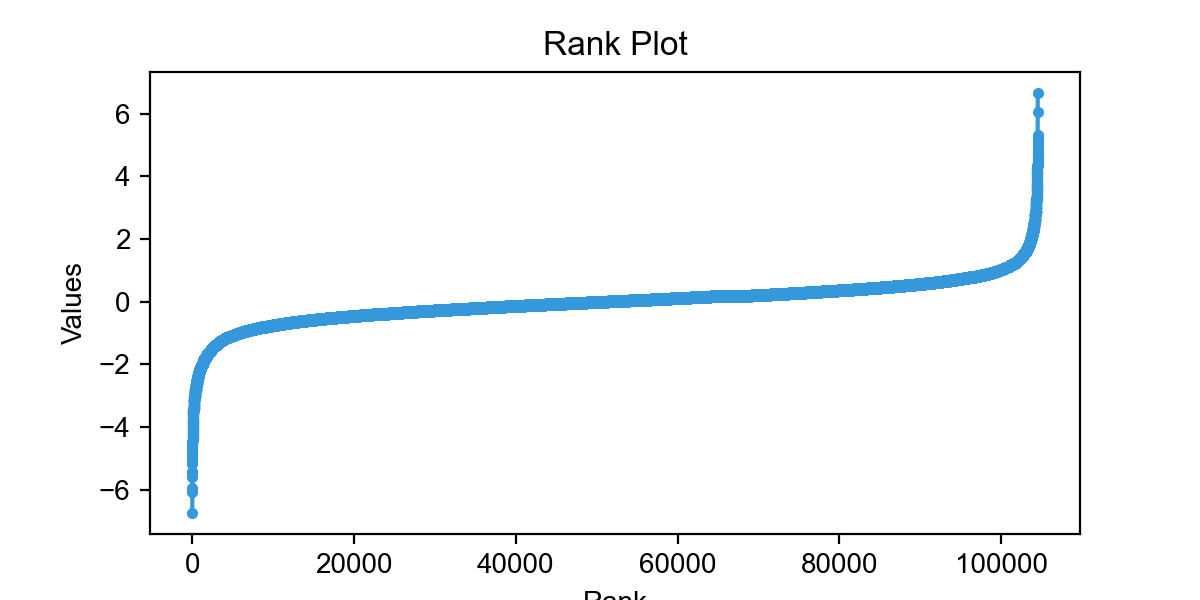

In [171]:
d = pdata.to_df().T['molm13_rho_replicate_2'].T

rank_plot(d,d.sort_values()[:10].index)

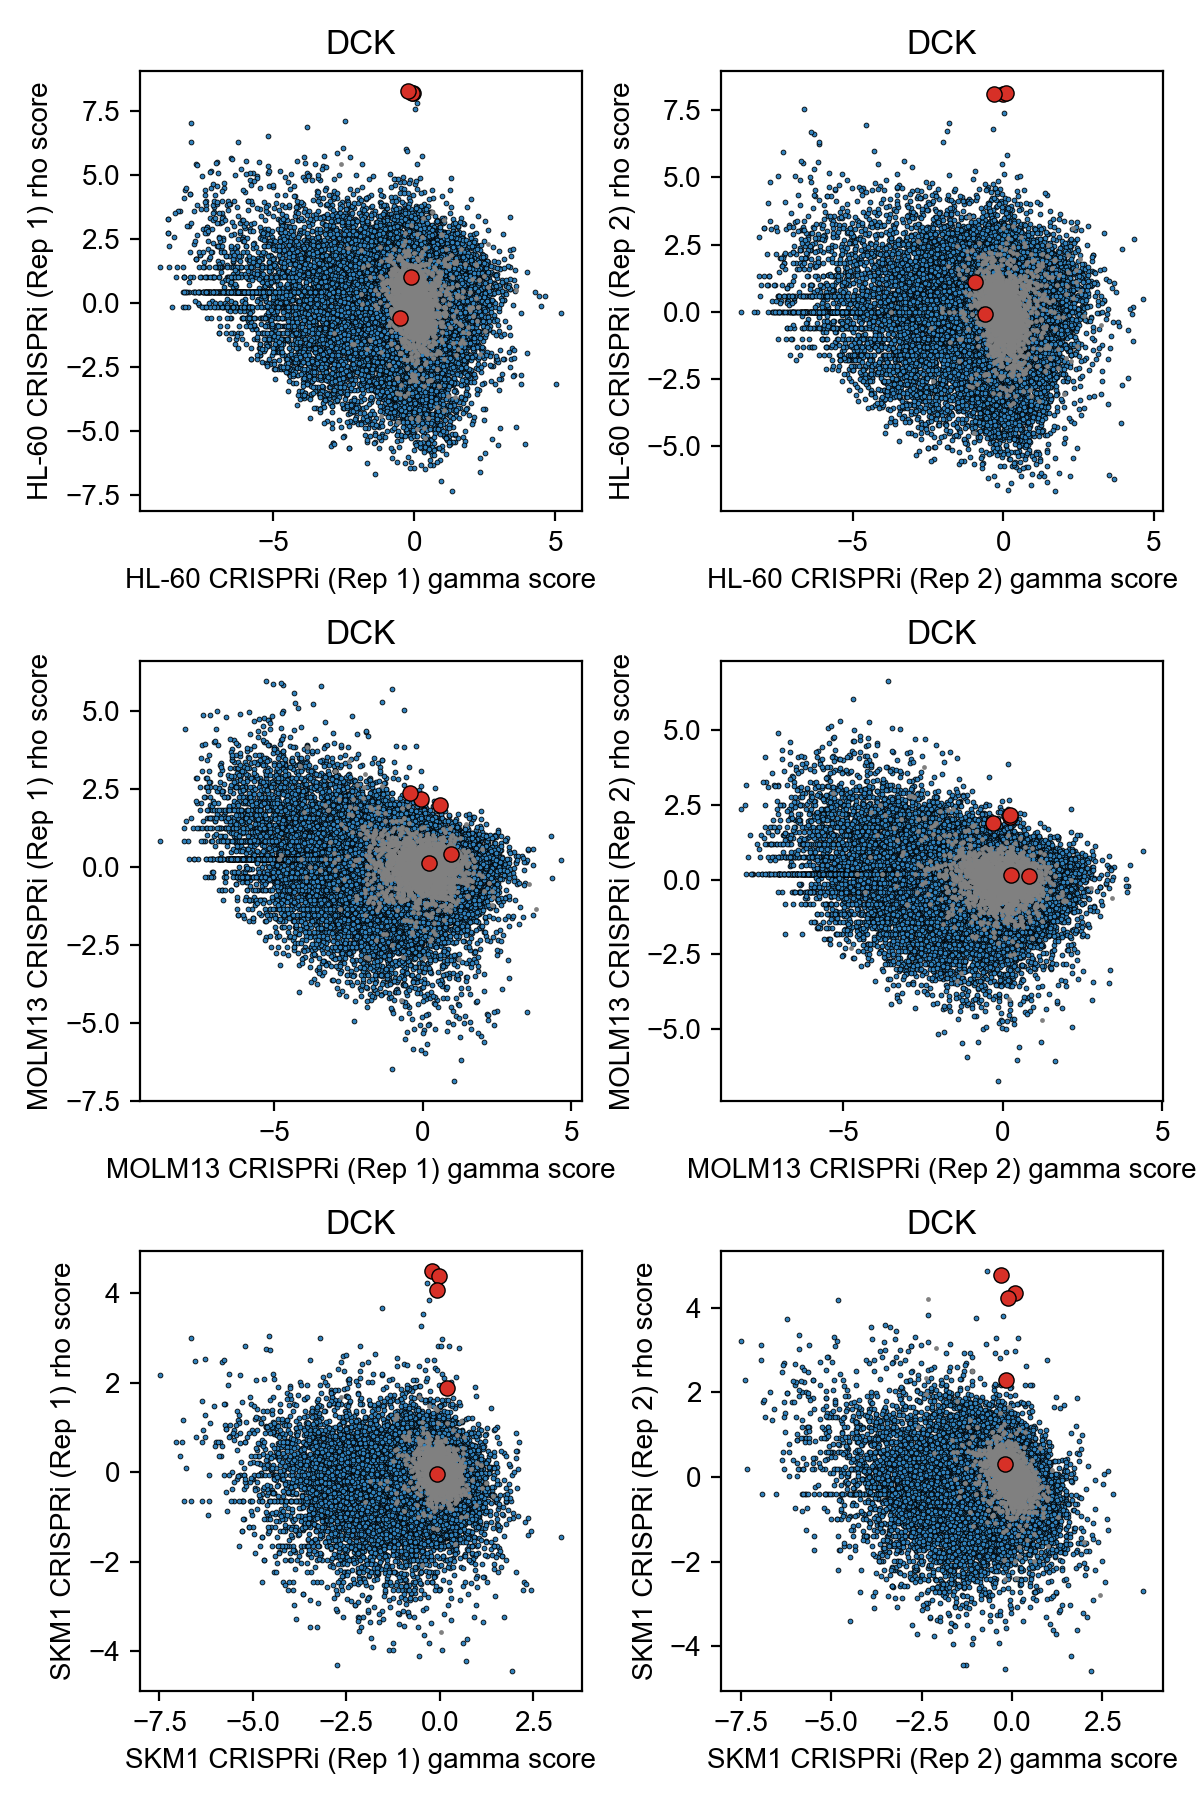

In [21]:
plot_scatter_for_a_gene_on_three_cell_lines('DCK')

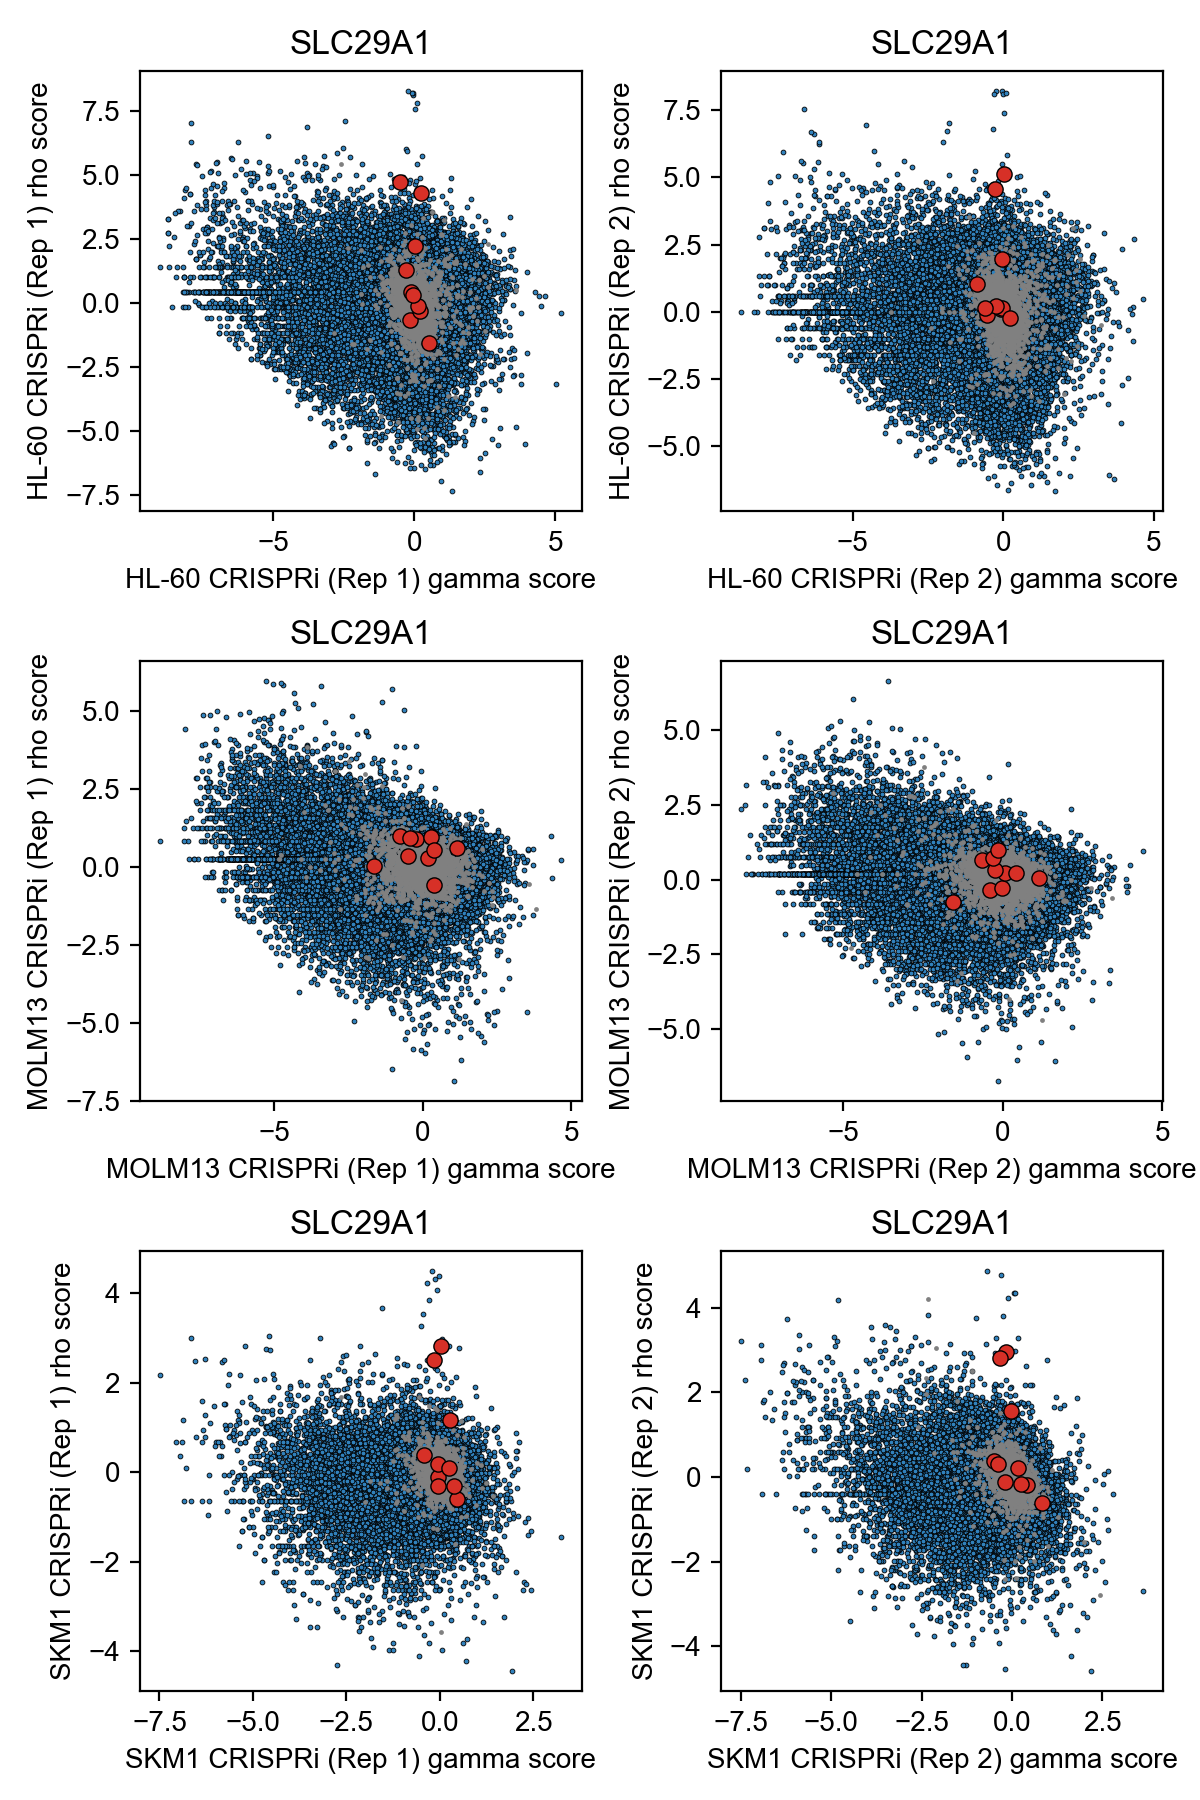

In [22]:
plot_scatter_for_a_gene_on_three_cell_lines('SLC29A1')

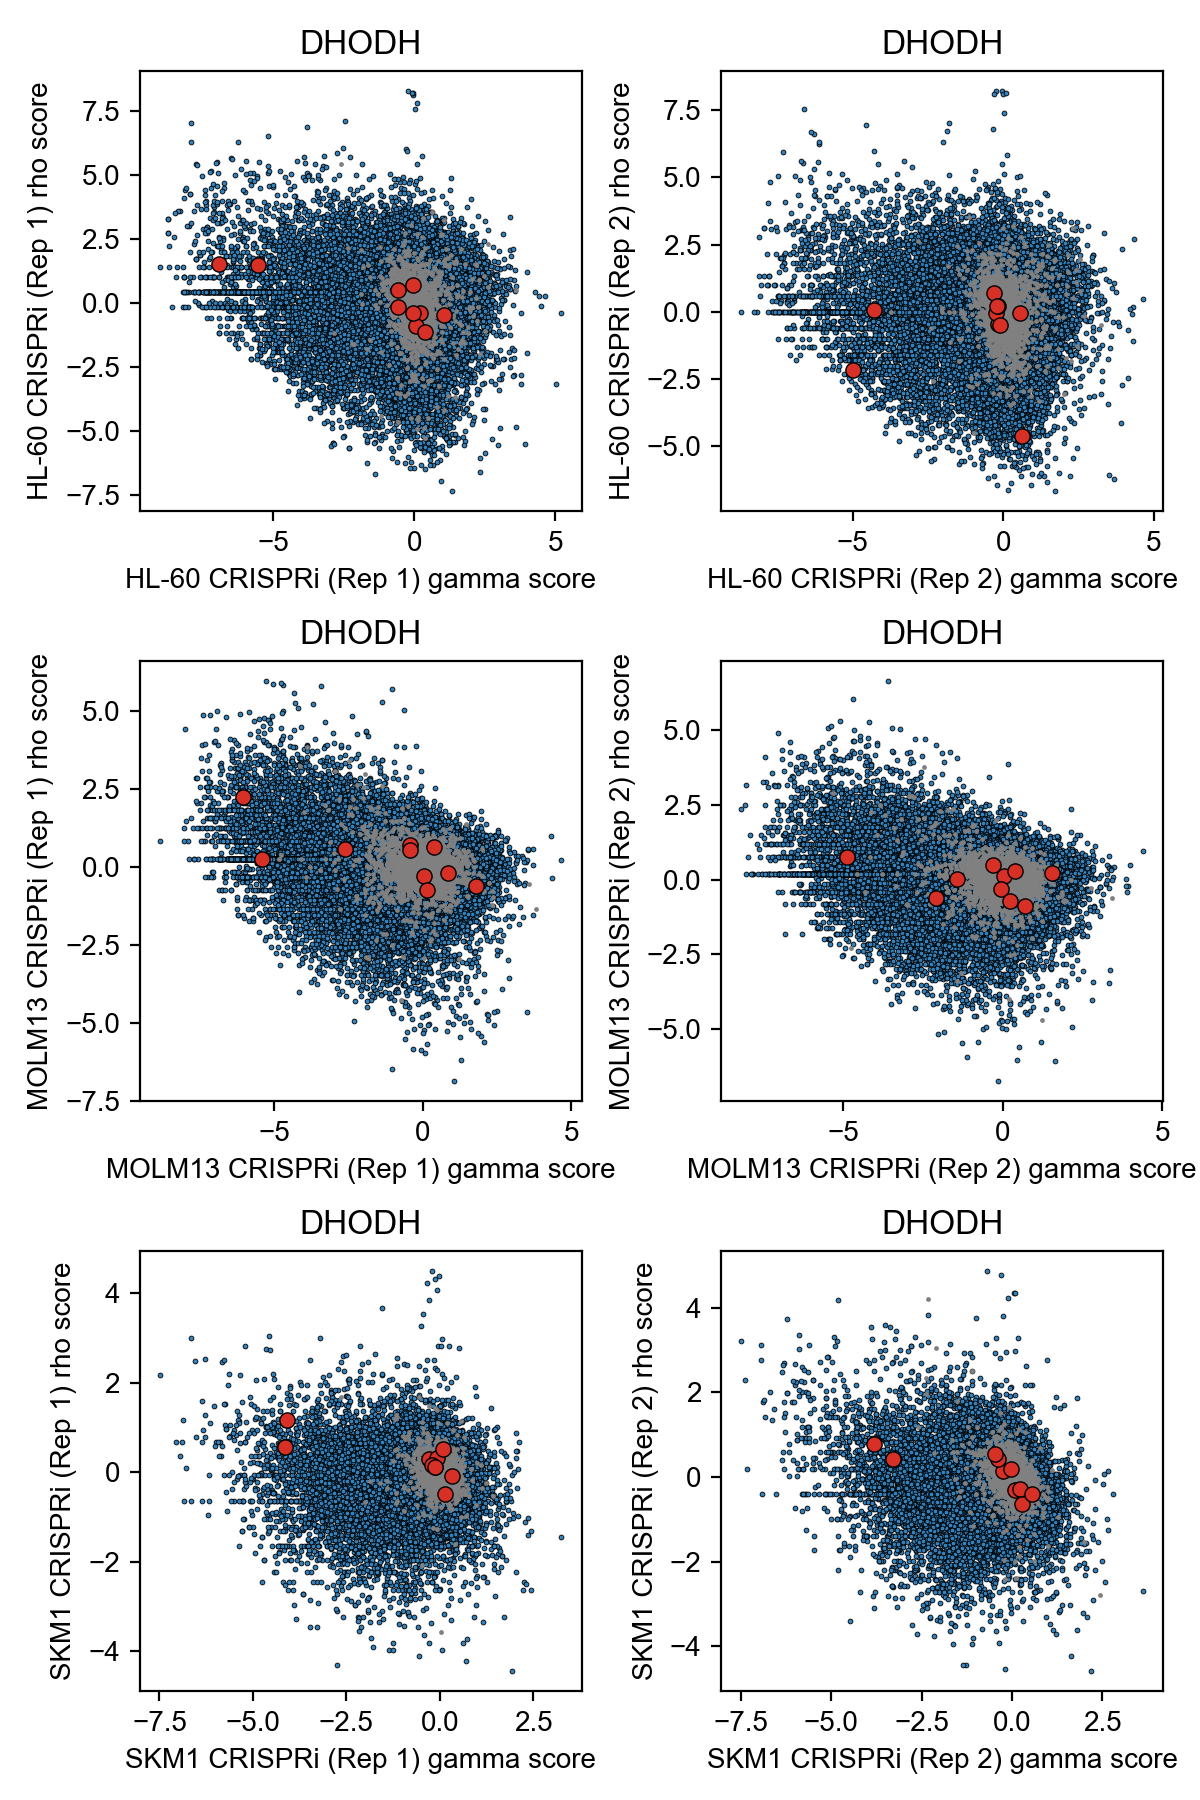

In [57]:
plot_scatter_for_a_gene_on_three_cell_lines('DHODH')

# 

In [172]:
Ca_library = pd.read_csv('../DAC/CRISPRa-screen/CRISPRa_v2_mouse_librarytable.txt',sep='\t',index_col=0)
Ca_library.rename(columns={'gene':'target'},inplace=True)
Ca_library['targetType'] = Ca_library.target.apply(lambda x: "negCtrl" if x == "negative_control" else "targeting")
Ca_library = Ca_library.sort_values('target').sort_values('targetType',ascending=False)
Ca_library.targetType = pd.Categorical(Ca_library.targetType,categories=['targeting','negCtrl'])

Ca = pd.read_csv(
    '../DAC/CRISPRa-screen/GSE240570_raw_counts.txt.gz',
    sep='\t',header=[0,1],index_col=0
)
meta = Ca.columns.to_frame(name=['condition','replicate']).reset_index(drop=True)
meta.replicate = meta.replicate.str[-1].astype(int)

Ca_screen = scp.ScreenPro(
    ad.AnnData(
        Ca.T.reset_index(drop=True),
        var=Ca_library.loc[Ca.index,:],
        obs=meta
    )
)

/data_gilbert/home/aarab/anaconda3/envs/mamba/envs/screenpro2/lib/python3.9/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.


In [173]:
Ca_phe = pd.concat([
    get_replicate_score(Ca_screen,x_label='DMSO',y_label='DAC').add_prefix('rho_'),
    get_replicate_score(Ca_screen,x_label='T0',y_label='DMSO').add_prefix('gamma_'),
],axis=1)

Ca_phe = pd.concat([Ca_phe, Ca_library.loc[Ca_phe.index,]],axis=1)

In [176]:
# plot_scatter_with_annotations(
#     Ca_phe,
#     gamma='gamma_replicate_1',
#     rho='rho_replicate_1',
#     target_name='Dck',
#     exp = 'CRISPRa'
# )

# plot_scatter_with_annotations(
#     Ca_phe,
#     gamma='gamma_replicate_1',
#     rho='rho_replicate_1',
#     target_name='Slc29a1',
#     exp = 'CRISPRa'
# )

In [182]:
# d = Ca_phe['gamma_replicate_1'].T

# rank_plot(d,d.sort_values()[:10].index)

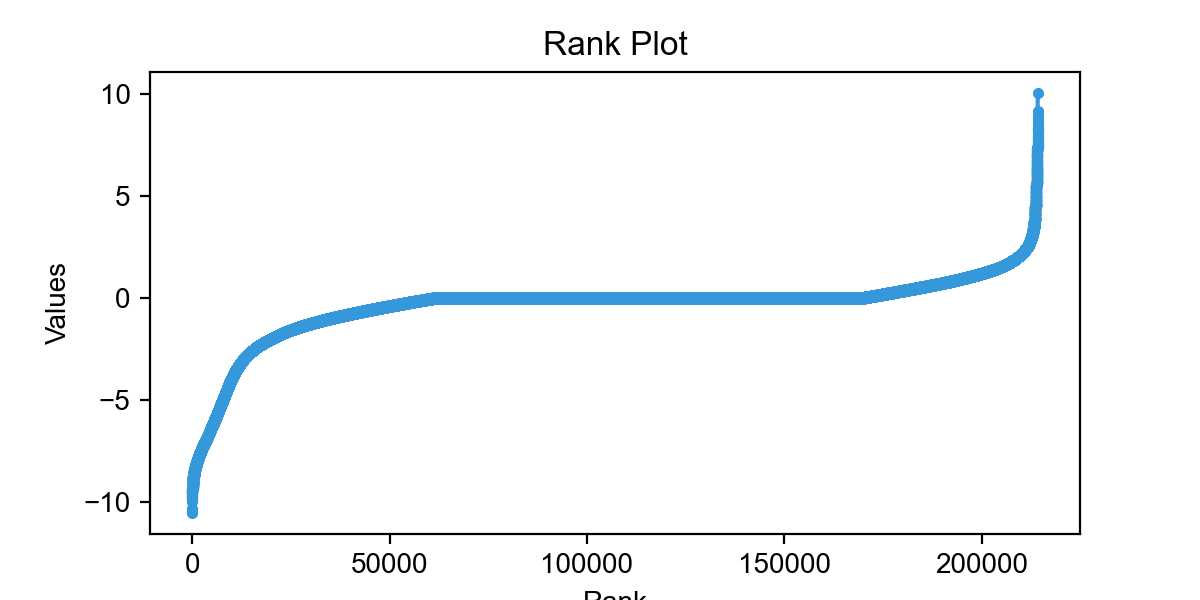

In [181]:
d = Ca_phe['rho_replicate_1'].T

rank_plot(d,d.sort_values()[:10].index)

# 

In [61]:
# from upsetplot import from_contents,UpSet

# import sys

# sys.path.append('../scripts/')

# from util import find_top

In [62]:
# def read_rho_phenotype_table(screen_path):
#     df = pd.read_csv(
#             f'{screen_path}/genetable_collapsed.txt',
#             sep='\t',
#             header=list(range(3)), 
#             index_col=list(range(1))
#         )['rho']['ave_Rep1_Rep2'].reset_index()[
#         ['gene','average phenotype of strongest 3','Mann-Whitney p-value']
#     ]
#     df.columns = ['target','rho score','pvalue']
#     df = scp.utils.ann_score_df(df,ctrl_label='pseudo')
#     return df.set_index('target')

In [63]:
# pd.concat([
#     read_rho_phenotype_table(f'{wd}/CRISPRi-screen/hl60_exp1/').add_prefix('hl60_'),
#     read_rho_phenotype_table(f'{wd}/CRISPRi-screen/skm1_exp/').add_prefix('skm1_'),
#     read_rho_phenotype_table(f'{wd}/CRISPRi-screen/molm13_exp/').add_prefix('molm13_'),
# ],axis=1)

In [ ]:
Exp_up = set(Top['Exp']['up'].gene_name.to_list())# + u[1].gene_name.tolist())
Rho_up = set(Top['Rho']['up'].index.tolist())
Stbl_up = set(Top['Stbl']['up'].gene_name.tolist())
TE_up = set(Top['TE']['up'].gene_name.tolist())
Hyper_m6A = set(Top['Mtyl']['up'].gene_name.tolist())

Exp_down = set(Top['Exp']['down'].gene_name.tolist())# + d[1].gene_name.tolist())
Stbl_down = set(Top['Stbl']['down'].gene_name.tolist())
Rho_down = set(Top['Rho']['down'].index.tolist())
TE_down = set(Top['TE']['down'].gene_name.tolist())
Hypo_m6A = set(Top['Mtyl']['down'].gene_name.tolist())

In [ ]:
'MYBBP1A' in Rho_down 

In [ ]:
'INTS5' in Exp_down

In [ ]:
upset_data = {
    'Hyper_m6A':Hyper_m6A,
    # 'Hypo_m6A':Hypo_m6A,

    'Exp_up':Exp_up,
    'Rho_up':Rho_up,
    # 'Stbl_up':Stbl_up,
    'TE_up':TE_up,

    'Exp_down':Exp_down,
    # 'Stbl_down':Stbl_down,
    'Rho_down':Rho_down,
    'TE_down':TE_down
}

In [ ]:
with PdfPages('intersectional-genes/comparisons_upset_plot.pdf') as pdf:
    # Hyper_m6A_upset_data
    fig1 = plt.figure()
    upset1 = us.UpSet(
        us.from_contents(upset_data),
        min_degree=3,
        sort_by='cardinality',
        # orientation='vertical',
        show_counts=True,
        # totals_plot_elements=
        other_dots_color=0.2,
        facecolor='lightgrey'
    )
    upset1.style_subsets(
        present=["Rho_down","Hyper_m6A"], 
        # absent='Hypo_m6A',
        label="Hyper m6A & Rho down", 
        facecolor='brown'
        #, edgecolor='dimgrey',linewidth=0.5,linestyle='--'
    )
    
    upset1.style_subsets(
        present=["Exp_down","Hyper_m6A"], 
        # absent='Hypo_m6A',
        label="Hyper m6A & Exp down", 
        # facecolor='brown', 
        edgecolor='darkgreen',linewidth=2#,linestyle='--'
    )

    upset1.plot(fig=fig1)
    plt.title('Differential analysis intersections',fontsize=12)
    pdf.savefig(bbox_inches='tight')

In [64]:
import sys

sys.path.append('/data_gilbert/home/aarab/tools/pager/')

import upsetplot as us
import pager
from matplotlib.backends.backend_pdf import PdfPages

from IPython.display import IFrame

# from util import load_data

In [65]:
# scrns = load_data(screens=True,wd=wd)

In [66]:
import blitzgsea as blitz

In [67]:
# import pypage
# from pypage import ExpressionProfile
# from pypage import GeneSets
# from pypage import PAGE

In [68]:
pagerdir='/data_gilbert/home/aarab/tools/pager'

In [69]:
msigdb_c5_go = blitz.enrichr.read_gmt(f'{pagerdir}/annotations/human/msigdb_v7.4_c5.go/c5.go.v7.4.symbols.gmt')

# 

In [72]:
%reload_ext watermark

In [73]:
%watermark

Last updated: 2023-12-10T00:35:12.801289-08:00

Python implementation: CPython
Python version       : 3.9.16
IPython version      : 8.14.0

Compiler    : GCC 11.3.0
OS          : Linux
Release     : 3.10.0-957.27.2.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 64
Architecture: 64bit



In [74]:
%watermark --iversions

blitzgsea : 1.3.34
pandas    : 2.0.3
upsetplot : 0.8.0
screenpro : 0.2.5
anndata   : 0.9.1
sys       : 3.9.16 | packaged by conda-forge | (main, Feb  1 2023, 21:39:03) 
[GCC 11.3.0]
matplotlib: 3.7.2
scanpy    : 1.9.3



In [75]:
!date

Sun Dec 10 00:35:15 PST 2023
